In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [51]:
lang_codes = ["ja", "ko", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
df_interventions = pd.read_csv('data/interventions.csv')
agg['ja']

len                                                 1197856
sum       {'2018-01-01 00:00:00': 7828155, '2018-01-02 0...
covid     {'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...
topics    {'Culture.Biography.Biography*': {'len': 14904...
Name: ja, dtype: object

In [55]:
pre_covid_dfs = []
covid_dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

for language in lang_codes:
    language_data = agg[language]
    language_data_mobile = agg[language + '.m']
    
    all_sum = pd.Series(language_data['sum']) + pd.Series(language_data_mobile['sum'])
    
    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)

    closure_date = df_interventions[df_interventions['lang'] == language]['School closure'].iloc[0]
    for topic, topic_data in language_data["topics"].items():
        if topic[:9] == 'Geography':
            continue

        topic_data_mobile = language_data_mobile["topics"][topic]
        topic_sum = pd.Series(topic_data['sum']) + pd.Series(topic_data_mobile['sum']) # number of pageviews per day for a topic
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'language': [language] * len(topic_sum),
            'date': pd.to_datetime(topic_sum.index),
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        pre_covid_dfs.append(topic_df[topic_df['date'] < closure_date])
        covid_dfs.append(topic_df[topic_df['date'] >= closure_date])
        
pre_covid_df = pd.concat(pre_covid_dfs, ignore_index=True)
covid_df = pd.concat(covid_dfs, ignore_index=True)

In [68]:
pre_covid_prop = pre_covid_df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['mean'])
covid_prop = covid_df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['mean'])

topics = pre_covid_prop.index.get_level_values('topic').unique()
pre_covid_correlation = []
covid_correlation = []

for topic in topics:
    for dim in hofstede.columns:
        pre_covid_series = pre_covid_prop.loc[topic]['proportion']
        pre_covid_series.index = pre_covid_series.index.map(code_dict)
        pre_covid_series = pre_covid_series.sort_index()

        covid_series = covid_prop.loc[topic]['proportion']
        covid_series.index = covid_series.index.map(code_dict)
        covid_series = covid_series.sort_index()

        pre_covid_correlation.append({'topic': topic, 'dimension': dim, 'correlation': hofstede[dim].corr(pre_covid_series['mean'])})
        covid_correlation.append({'topic': topic, 'dimension': dim, 'correlation': hofstede[dim].corr(covid_series['mean'])})
pre_covid_corr_df = pd.DataFrame(pre_covid_correlation).pivot(index='topic', columns='dimension', values='correlation')
covid_corr_df = pd.DataFrame(covid_correlation).pivot(index='topic', columns='dimension', values='correlation')

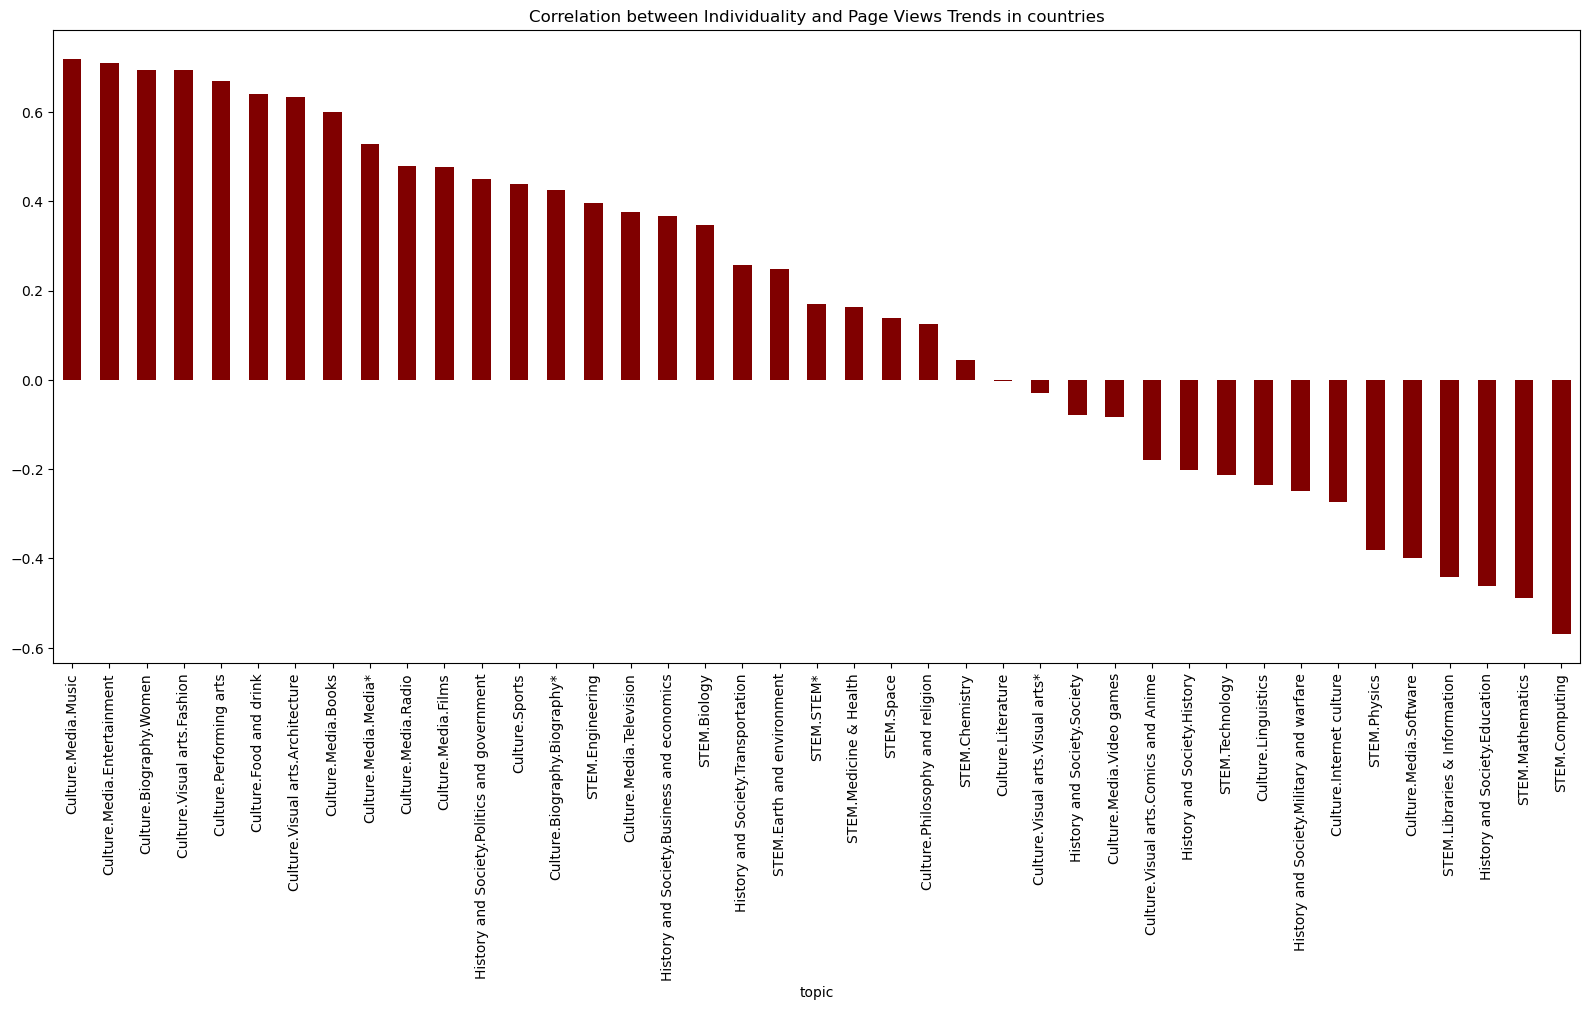

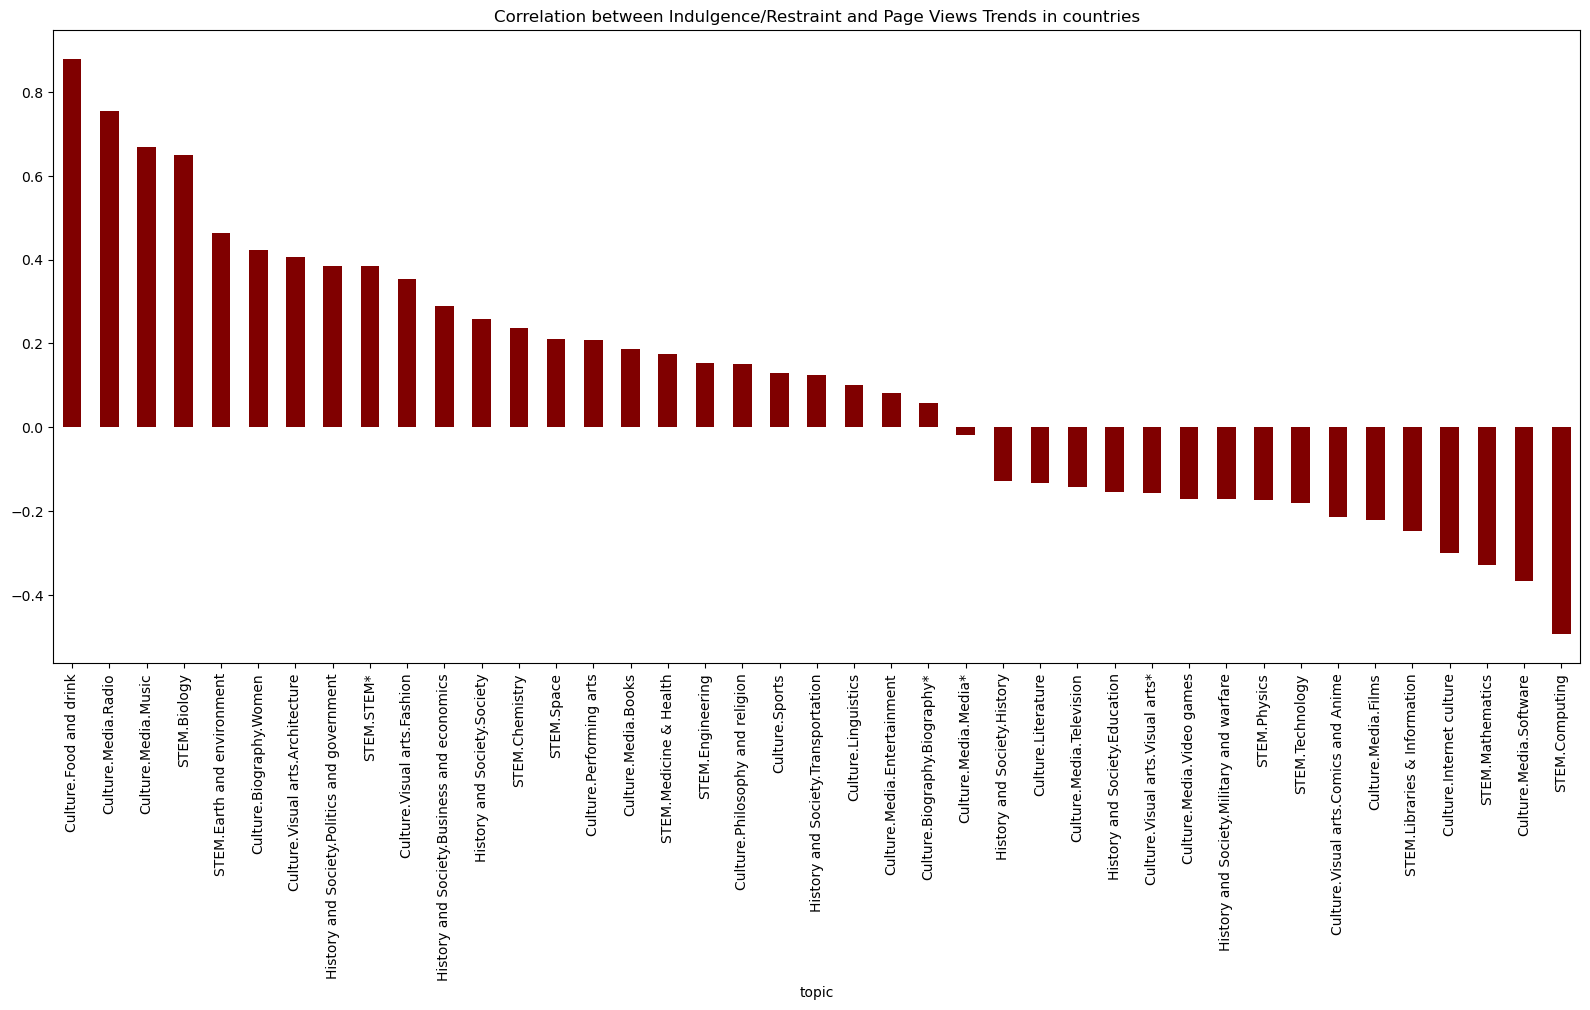

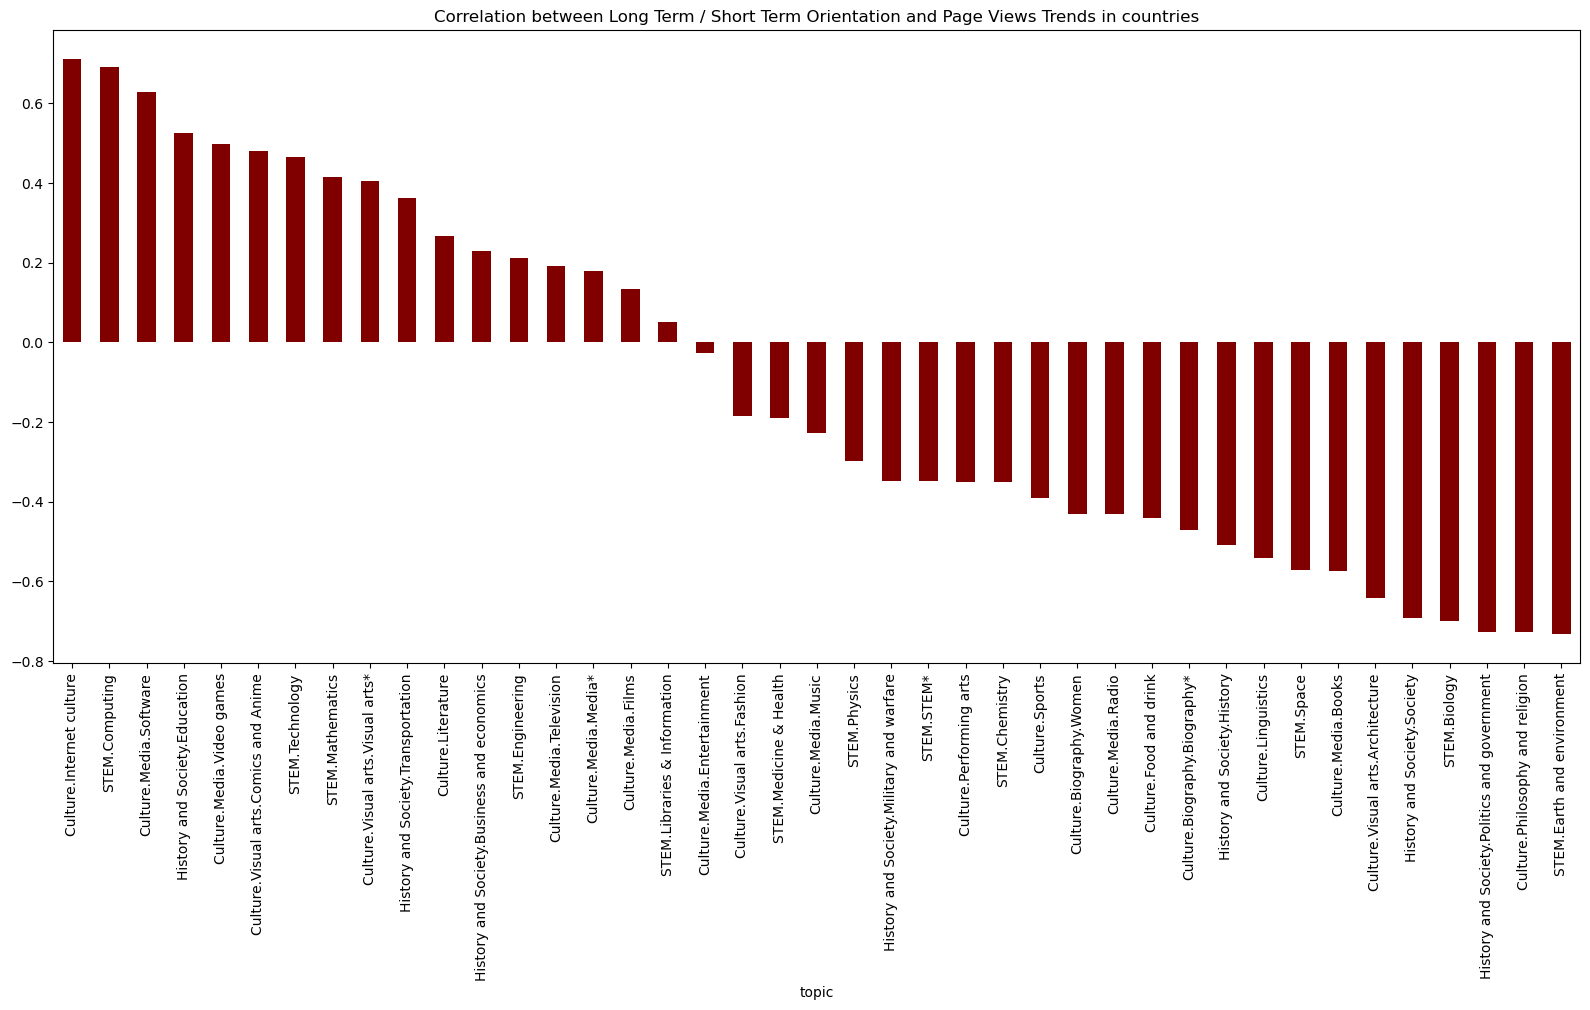

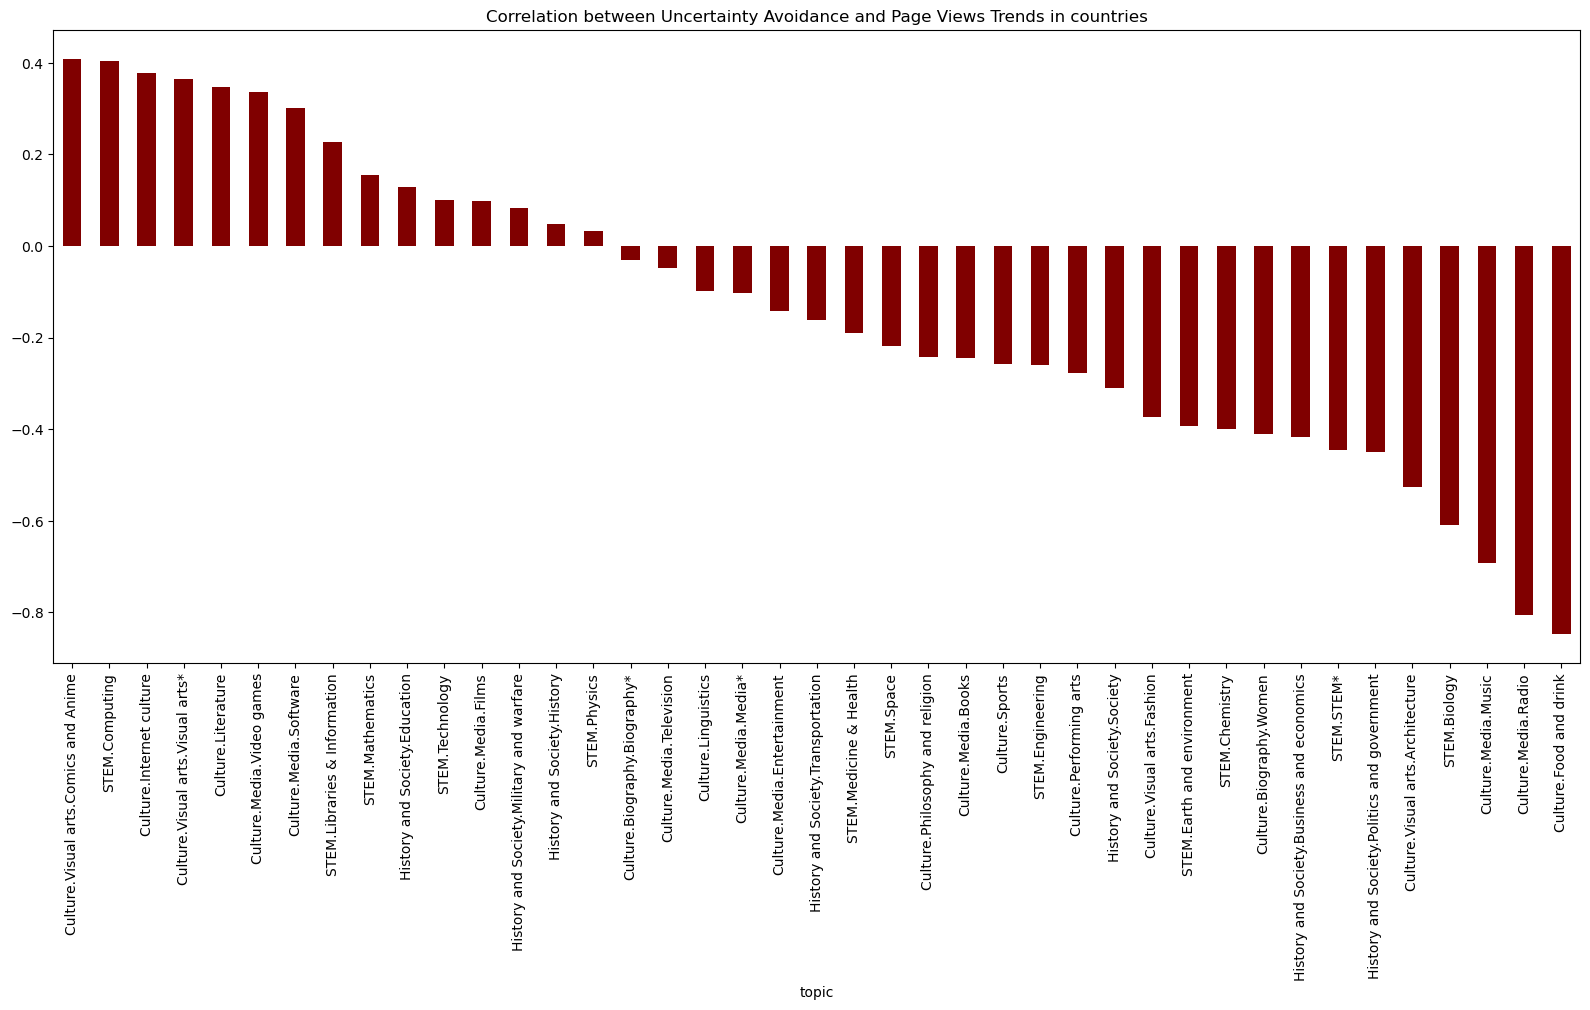

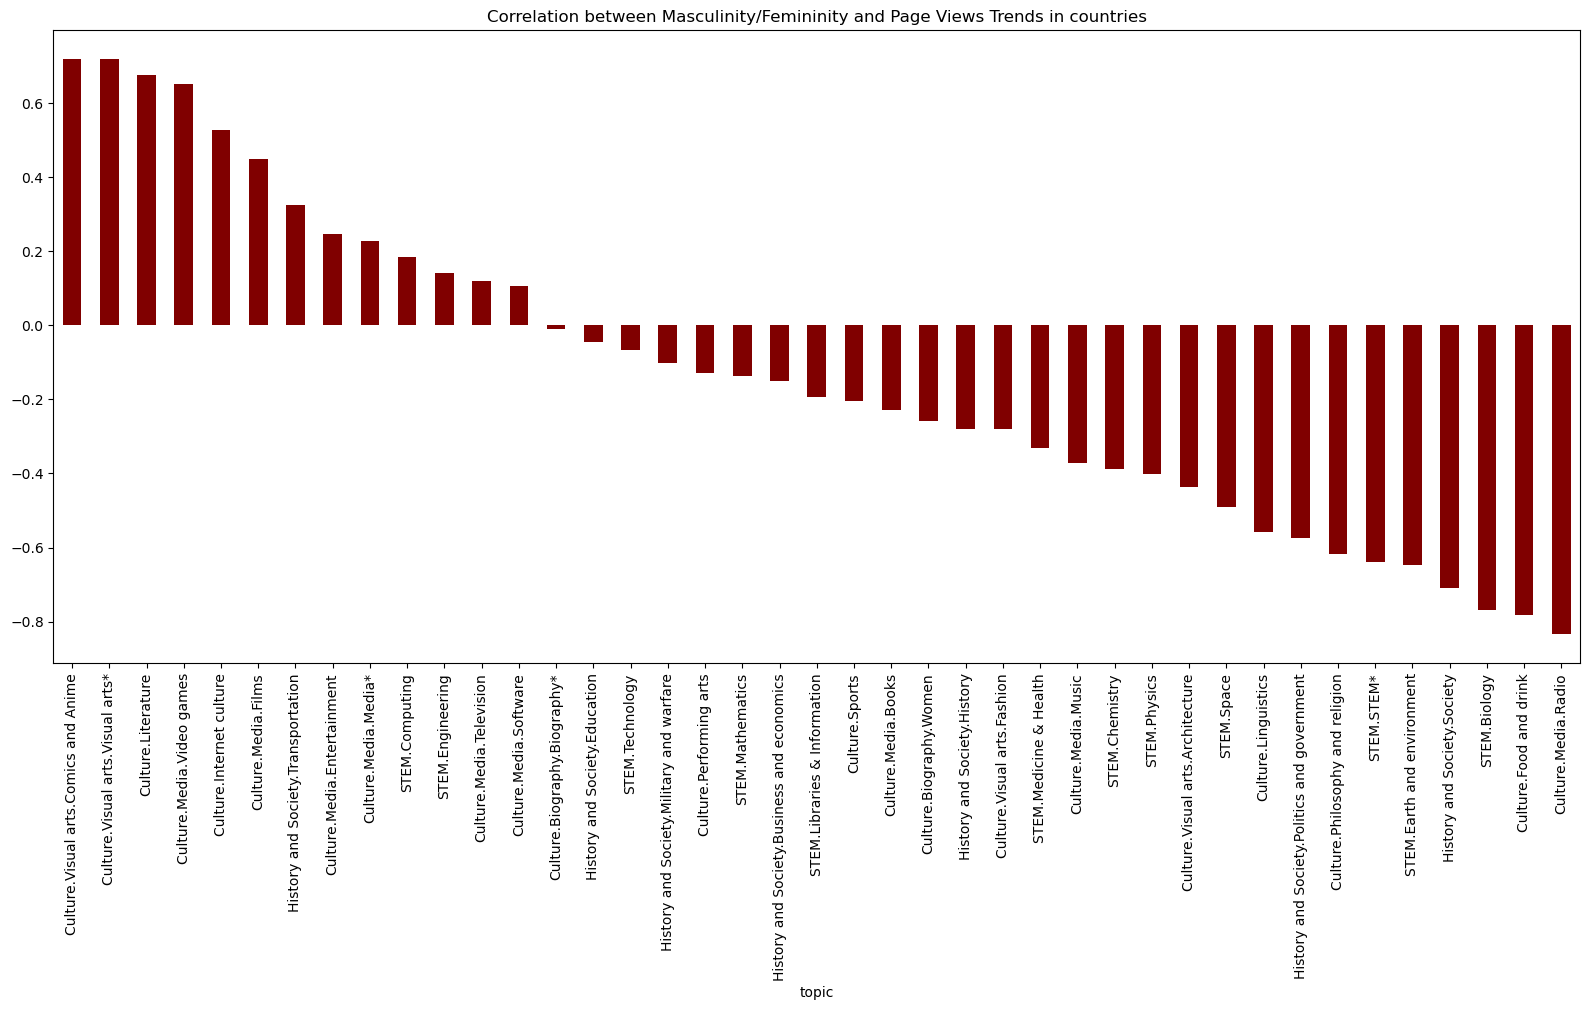

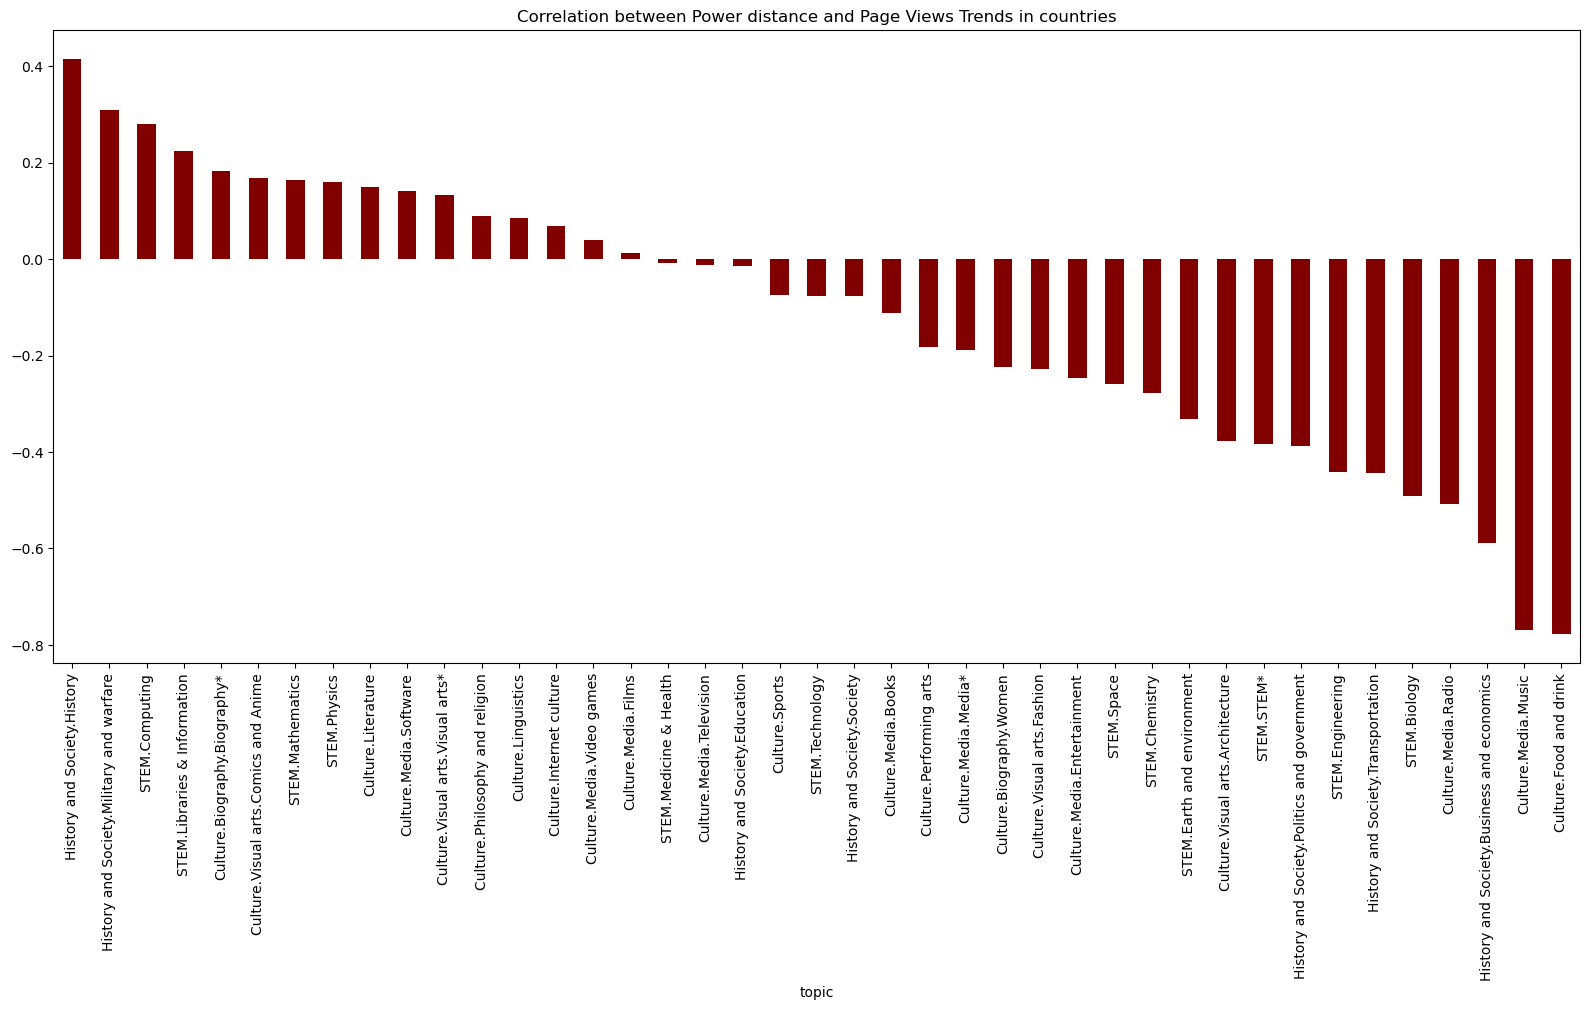

In [101]:
dimensions = {'idv': 'Individuality', 'ivr' : 'Indulgence/Restraint', 'ltowvs' : 'Long Term / Short Term Orientation', 'uai': 'Uncertainty Avoidance', 'mas': 'Masculinity/Femininity', 'pdi': 'Power distance'}
for dim, description in dimensions.items():
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    pre_covid_corr_df[dim].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
    fig.tight_layout()
    ax.set_title("Correlation between " + description + " and Page Views Trends in countries")

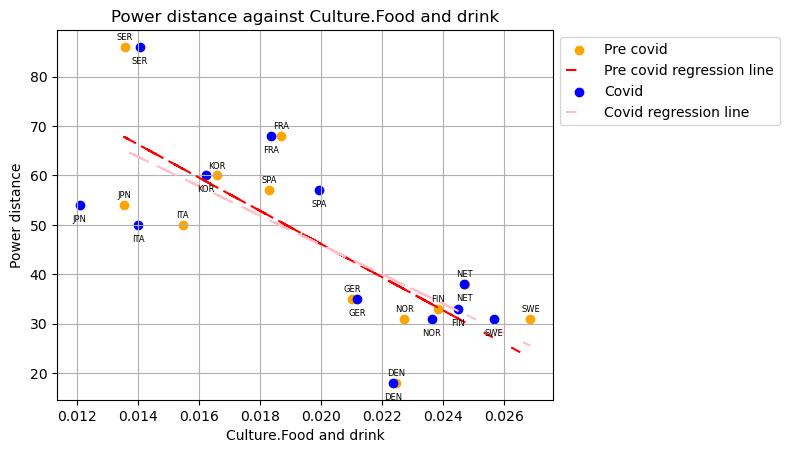

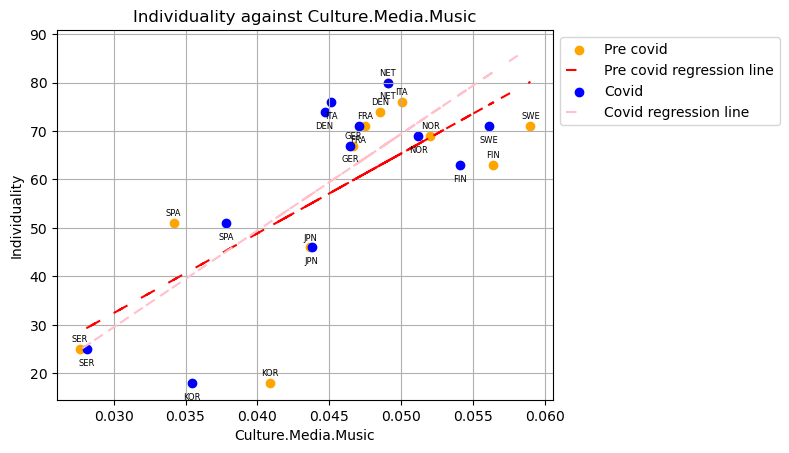

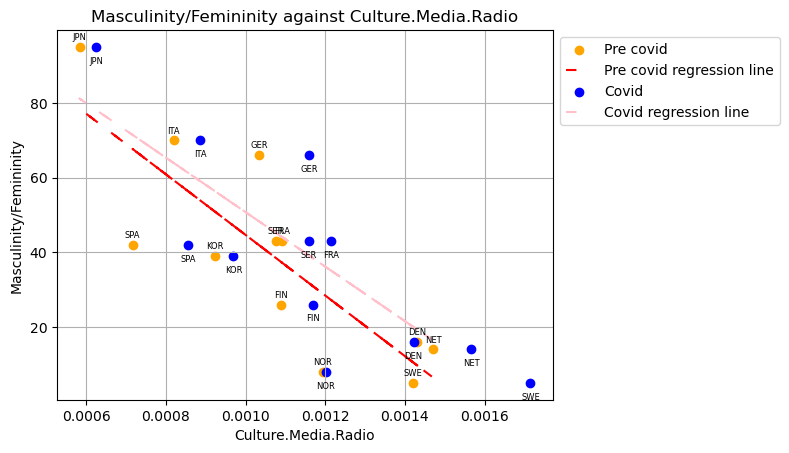

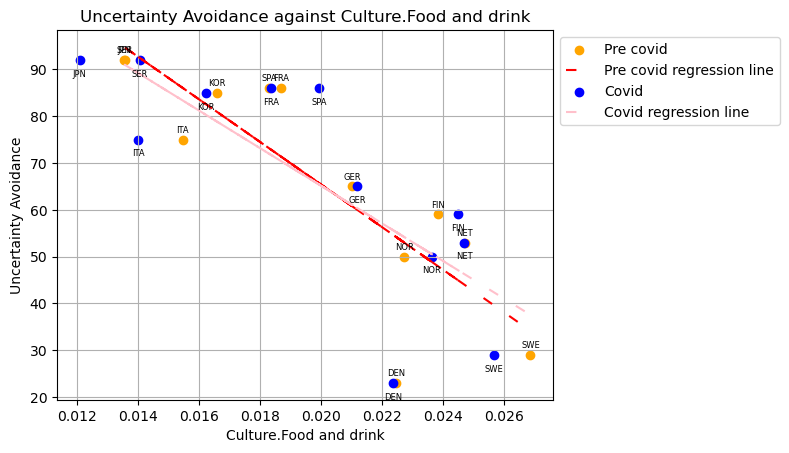

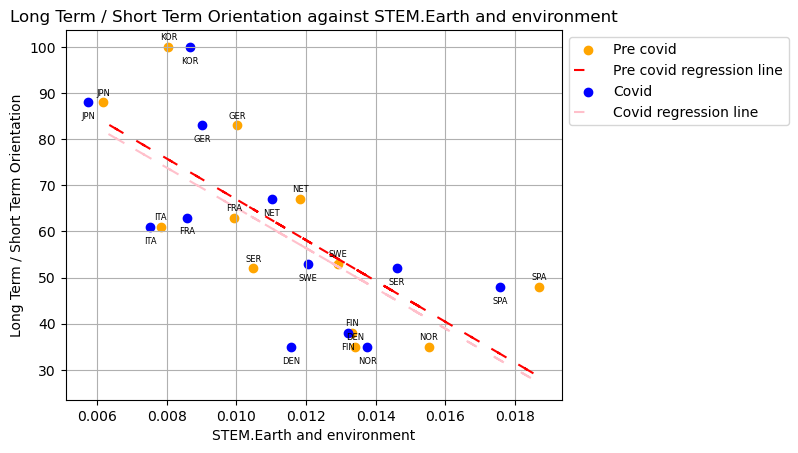

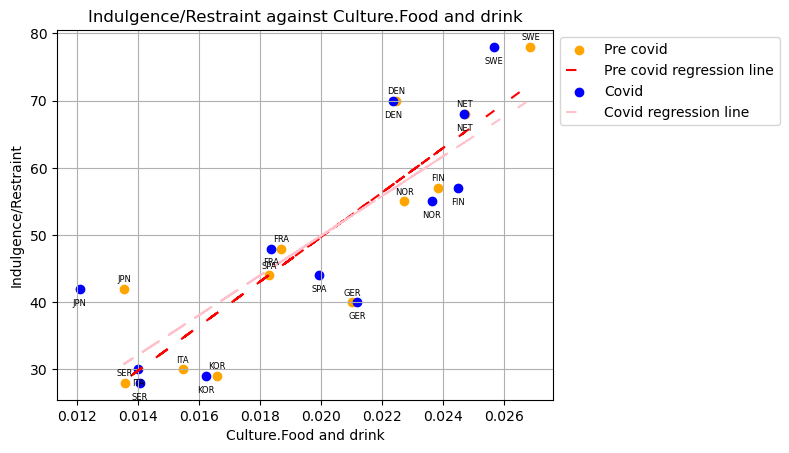

In [127]:
# Now that we understand which topics relate to which cultural dimensions, we can try to analyse the influence of COVID on cultural 

for dim in hofstede.columns:
    topic = np.abs(pre_covid_corr_df[dim]).sort_values().idxmax()
    pre_covid_proportions = pre_covid_prop.loc[topic]['proportion']
    pre_covid_proportions.index = pre_covid_proportions.index.map(code_dict)
    pre_covid_proportions = pre_covid_proportions.sort_index()
    
    x = pre_covid_proportions.values.flatten()
    y = hofstede[dim].values
    plt.figure()
    plt.scatter(x, y, color='orange', label='Pre covid')
    plt.grid(True)
    for i, label in enumerate(pre_covid_proportions.index):
        plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

    m, c = np.polyfit(x, y, 1)
    plt.plot(x, m*x + c, color='red', linestyle=(0, (5, 10)), label='Pre covid regression line')

    covid_proportions = covid_prop.loc[topic]['proportion']
    covid_proportions.index = covid_proportions.index.map(code_dict)
    covid_proportions = covid_proportions.sort_index()
    newx = covid_proportions.values.flatten()
    plt.scatter(newx,y, color='blue', label='Covid')
    for i, label in enumerate(pre_covid_proportions.index):
        plt.annotate(label, (newx[i], y[i]), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=6)

    m, c = np.polyfit(newx, y, 1)
    plt.plot(x, m*x + c, color='pink', linestyle=(0, (5, 10)), label='Covid regression line')

    plt.title(dimensions[dim] + ' against ' + topic)
    plt.xlabel(topic)
    plt.ylabel(dimensions[dim])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)


In [27]:
df__ = pd.DataFrame({'Topics views': x, 'Hofstede Score': y, 'language' : ctr_codes})

In [28]:
df__.set_index('language', inplace=True)

/Users/Paolo/opt/anaconda3/envs/ADA/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.5553487860521487


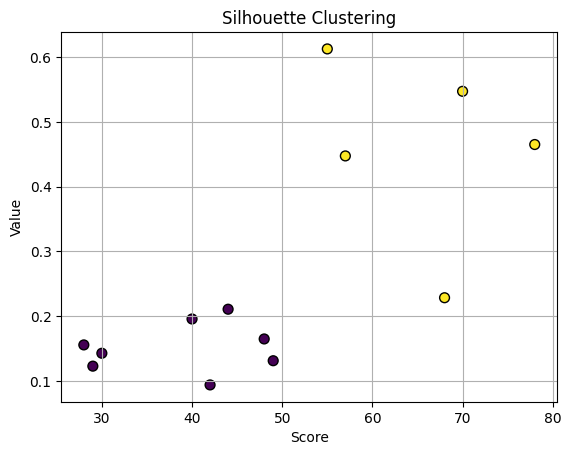

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



# Standardize the data (optional but recommended for KMeans)
scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)
pipeline = make_pipeline(scaler, kmeans)

# Fit the KMeans model
df__['Cluster'] = pipeline.fit_predict(df__[['Hofstede Score', 'Topics views']])

# Calculate silhouette score
silhouette_avg = silhouette_score(df__[['Hofstede Score', 'Topics views']], df__['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Plot the clustered data
plt.scatter(df__['Hofstede Score'], df__['Topics views'], c=df__['Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title('Silhouette Clustering')
plt.xlabel('Score')
plt.ylabel('Value')
plt.grid(True)
plt.show()
